# LSTM Analysis Notebook

In [17]:
import os
import re
import glob
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Get data
---
### 1.1 Ground Truth

In [18]:
data = []
for player in glob.glob('../LSTM-Neural-Network-for-Time-Series-Prediction/data/*.csv'):
    tmp = pd.read_csv(player)
    data.append(tmp)
data = pd.concat(data)

In [19]:
data.head()

,Unnamed: 0,Game_Id,Team,Player,Player_Id,Date,Goal,First_Assist,Second_Assist,Total_Points
0,412,2013_20014,VAN,RYAN KESLER,8470616,2013-10-03 00:00:00,0.0,0.0,0.0,0.0
1,1024,2013_20030,VAN,RYAN KESLER,8470616,2013-10-05 00:00:00,1.0,0.0,0.0,1.0
2,1174,2013_20034,VAN,RYAN KESLER,8470616,2013-10-06 00:00:00,0.0,0.0,0.0,0.0
3,1520,2013_20043,VAN,RYAN KESLER,8470616,2013-10-08 00:00:00,0.0,0.0,0.0,0.0
4,2016,2013_20056,VAN,RYAN KESLER,8470616,2013-10-10 00:00:00,0.0,0.0,0.0,0.0


In [20]:
years = ['20132014', '20142015', '20152016', '20162017', '20172018', '20182019']
start_date = [pd.datetime(2013, 10, 1), 
              pd.datetime(2014, 10, 1), 
              pd.datetime(2015, 10, 1), 
              pd.datetime(2016, 10, 1),
              pd.datetime(2017, 10, 1),
              pd.datetime(2018, 10, 1)]
end_date = [pd.datetime(2014, 4, 13), 
            pd.datetime(2015, 4, 11), 
            pd.datetime(2016, 4, 10), 
            pd.datetime(2017, 4, 9),
            pd.datetime(2018, 4, 8),
            pd.datetime(2019, 4, 6)]

yearly_data = {}
i = 0
for y in years:
    print(y)
    print('Points...')
    data['Date'] = pd.to_datetime(data['Date'])
    mask = (data['Date'] > start_date[i]) & (data['Date'] <= end_date[i])
    data_tmp = data.loc[mask]
    yearly_data[y] = data_tmp
    
    i+=1

20132014
Points...
20142015
Points...
20152016
Points...
20162017
Points...
20172018
Points...
20182019
Points...


In [21]:
data_1718 = yearly_data['20172018']
data_1718_agg = data_1718.groupby('Player_Id').agg({'Player': np.unique, 'Total_Points': sum})
data_1718_agg['Name'] = data_1718_agg.Player.apply(lambda player: re.sub(r'\W+', '', f'{player}').upper())
data_1718_agg.set_index('Name', inplace=True)
data_1718_agg.head()

,Player,Total_Points
Name,,
JAROMIRJAGR,JAROMIR JAGR,7.0
MATTCULLEN,MATT CULLEN,22.0
ZDENOCHARA,ZDENO CHARA,24.0
JOETHORNTON,JOE THORNTON,36.0
PATRICKMARLEAU,PATRICK MARLEAU,47.0


### 1.2 LSTM Predictions

In [22]:
preds = []
for player in glob.glob('../LSTM-Neural-Network-for-Time-Series-Prediction/data/*.pkl'):
    tmp = pd.read_pickle(player)
    tmp = pd.DataFrame.from_dict(tmp, orient='index')
    preds.append(tmp)
preds = pd.concat(preds)
preds['Player_Id'] = preds.apply(lambda x: x.name.split('.cs')[0].split('-')[-1], axis=1)

In [23]:
preds.head()

,multiple-sequences,full-sequence,point-by-point,train,test,Player_Id
MARTIN-BRODEUR-8455710.csv,[],"[0.11195018, 0.1063844]","[0.11195019, 0.11195019]","[2013-10-04 00:00:00, 2014-04-13 00:00:00]","[2014-12-04 00:00:00, 2015-01-02 00:00:00]",8455710
MATT-BELESKEY-8473492.csv,"[[0.5362535, 0.52454174, 0.5069729, 0.4838432,...","[0.5362535, 0.52454174, 0.5069729, 0.4838432, ...","[0.5362536, 0.52746135, 0.51705307, 0.50601286...","[2013-10-02 00:00:00, 2016-02-28 00:00:00]","[2016-03-01 00:00:00, 2018-12-14 00:00:00]",8473492
JANNIK-HANSEN-8471498.csv,"[[0.48771852, 0.48430762, 0.48627084, 0.489265...","[0.48771852, 0.48430762, 0.48627084, 0.4892657...","[0.48771855, 0.48374078, 0.48563272, 0.4906456...","[2013-10-03 00:00:00, 2016-10-16 00:00:00]","[2016-10-18 00:00:00, 2018-04-05 00:00:00]",8471498
NIC-PETAN-8477464.csv,"[[0.8500514, 1.8609679, 3.668315, 2.956638, 4....","[0.8500514, 1.8609679, 3.668315, 2.956638, 4.2...","[0.8500514, 1.7327857, 3.1345444, 1.4991868, 1...","[2015-10-08 00:00:00, 2016-04-09 00:00:00]","[2016-11-04 00:00:00, 2019-03-20 00:00:00]",8477464
TORREY-MITCHELL-8471338.csv,"[[0.2597915, 0.2624692, 0.26842433, 0.27740043...","[0.2597915, 0.2624692, 0.26842433, 0.27740043,...","[0.25979152, 0.25979152, 0.25979152, 0.2597915...","[2013-10-03 00:00:00, 2017-01-26 00:00:00]","[2017-01-31 00:00:00, 2018-04-02 00:00:00]",8471338


### 1.3 HMM Predictions

In [8]:
# Load HMM results
preds_hmm = pd.read_pickle('predictions_hmm_3years.pkl')
comparison = []
games = []
for name, player in preds_hmm.iterrows():
    player_id = name.split('-')[-1].split('.')[0]
    tmp = data[(data.Player_Id == int(player_id))&
                 (data.Date >= pd.datetime(2018, 10, 1))&
                 (data.Date <= pd.datetime(2019, 4, 6))]
    tmp_pts = tmp.Total_Points.sum()
    tmp_gms = tmp.shape[0]
    comparison.append(tmp_pts)
    games.append(tmp_gms)
preds_hmm['truth'] = comparison
preds_hmm['games'] = games
preds_hmm['Total_Points'] = 82*preds_hmm['truth']/preds_hmm['games']
preds_hmm = preds_hmm[preds_hmm['games'] > 10]

In [9]:
# Filter to have same players as in HMM analysis
preds = preds.join(preds_hmm)
preds = preds[preds['games'] > 10]
preds = preds[preds['mean'] > 0]

## 2. Analysis
---

In [24]:
comparison = data[(data.Player_Id == int(preds.iloc[1].Player_Id))&
                 (data.Date >= pd.to_datetime(preds.iloc[1].test[0]))&
                 (data.Date <= pd.to_datetime(preds.iloc[1].test[1]))][5:]
comparison['full-sequence'] = preds['full-sequence'].iloc[1]
comparison['point-by-point'] = preds['point-by-point'].iloc[1]
comparison.head()

,Unnamed: 0,Game_Id,Team,Player,Player_Id,Date,Goal,First_Assist,Second_Assist,Total_Points,full-sequence,point-by-point
186,153385,2016_21007,BOS,MATT BELESKEY,8473492,2016-03-10,0.0,0.0,0.0,0.0,0.536254,0.536254
187,153803,2016_21018,BOS,MATT BELESKEY,8473492,2016-03-12,0.0,0.0,0.0,0.0,0.524542,0.527461
188,154872,2016_21046,BOS,MATT BELESKEY,8473492,2016-03-15,0.0,0.0,0.0,0.0,0.506973,0.517053
189,155634,2016_21066,BOS,MATT BELESKEY,8473492,2016-03-18,0.0,0.0,0.0,0.0,0.483843,0.506013
190,156053,2016_21077,BOS,MATT BELESKEY,8473492,2016-03-19,0.0,0.0,0.0,0.0,0.499843,0.542198


In [25]:
%%time
comparison = []
for i, player in preds.iterrows():
    # Leave first five because of the sliding window (which takes last five before predicting the 82)
    tmp = data[(data.Player_Id == int(player.Player_Id))&
                     (data.Date >= pd.to_datetime(player.test[0]))&
                     (data.Date <= pd.to_datetime(player.test[1]))][5:]
    tmp['full-sequence'] = player['full-sequence']
    tmp['point-by-point'] = player['point-by-point']
    comparison.append(tmp)
comparison = pd.concat(comparison)
comparison.head()

CPU times: user 2min, sys: 1.99 s, total: 2min 1s
Wall time: 2min 12s


In [26]:
comparison_agg = comparison.groupby(['Player_Id', 'Player']).agg({'Date': 'count',
                                                                  'Total_Points': sum,
                                                                  'full-sequence': sum,
                                                                  'point-by-point': sum})

In [27]:
results = comparison_agg[['Total_Points']].copy()
results['Prediction'] = comparison_agg['point-by-point']
results['Difference'] = results['Prediction'] - results['Total_Points']
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,Total_Points,Prediction,Difference
count,1191.000000,1191.000000,1191.000000
mean,23.304786,23.711414,0.406628
std,22.822854,21.623096,10.426441
min,0.000000,-6.521999,-68.521999
10%,0.000000,0.565378,-10.825542
25%,3.000000,2.939618,-3.269752
50%,18.000000,19.657791,0.280454
75%,34.000000,35.629253,4.970628
90%,56.000000,53.934978,11.814985
max,132.000000,114.437836,48.005241


In [14]:
MAE = round(mean_absolute_error(results['Total_Points'], results['Prediction']), 2)
RMSE = round(mean_squared_error(results['Total_Points'], results['Prediction']), 2)
exp_var_score = round(explained_variance_score(results['Total_Points'], results['Prediction']), 2)
R2 = round(r2_score(results['Total_Points'], results['Prediction']), 2)

print('Mean Absolute Error:', MAE, 'points.')
print('Root Mean Squared Error:', RMSE, 'points.')
print('Explained Variance Score:', exp_var_score)
print('R2 Score:', R2)

Mean Absolute Error: 8.33 points.
Root Mean Squared Error: 138.58 points.
Explained Variance Score: 0.77
R2 Score: 0.77


In [15]:
# results = results.reset_index(level=1)
results.sort_values('Difference')

,,Total_Points,Prediction,Difference
Player_Id,Player,,,
8478440,DYLAN STROME,62.0,-6.521999,-68.521999
8477503,MAX DOMI,72.0,31.515903,-40.484097
8476979,ERIK GUSTAFSSON,61.0,21.740356,-39.259644
8475791,TAYLOR HALL,102.0,63.286415,-38.713585
8478414,TIMO MEIER,69.0,33.458656,-35.541344
8478483,MITCHELL MARNER,94.0,58.681221,-35.318779
8475168,MATT DUCHENE,79.0,44.033276,-34.966724
8479337,ALEX DEBRINCAT,77.0,43.026184,-33.973816
8477946,DYLAN LARKIN,83.0,49.275600,-33.724400


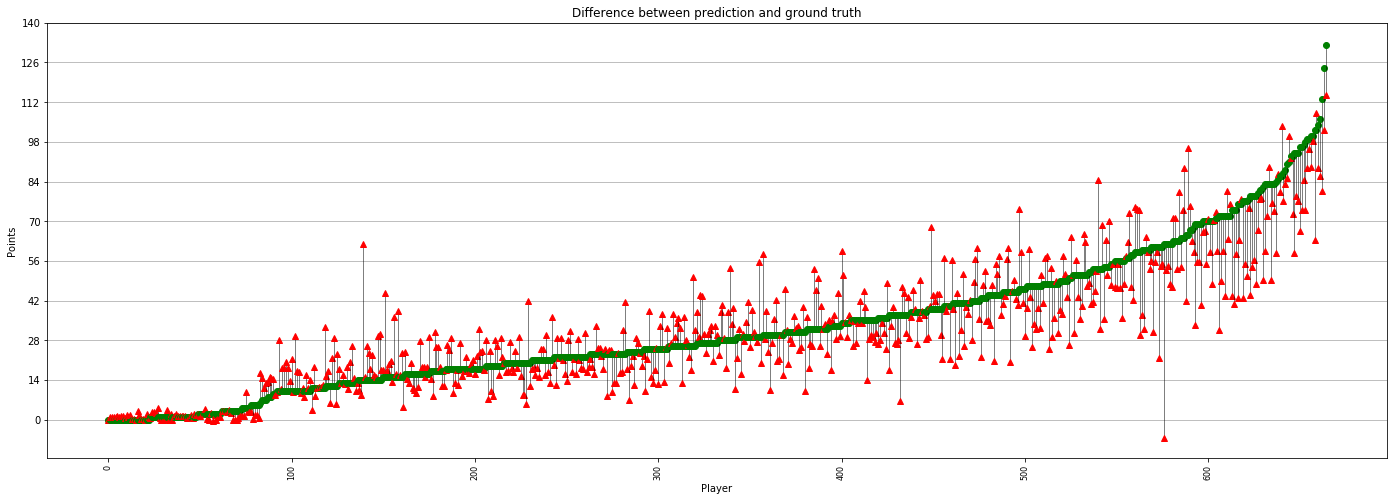

In [16]:
# Sorted indexes
sorted_index = np.argsort(results['Total_Points'])
predictions = results['Prediction']
labels = results['Total_Points']

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(i, labels[sorted_index][i], 'o', label='Ground Truth', color = 'g')
    ax.plot(i, predictions[sorted_index][i], '^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 140, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();